In [1]:
from utils import *
from trimesh import *
from optimal import OptimalSWF
from swf import *
from constants import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def Ambisonics_order3_encoding(theta,phi):
    try:
        W = np.ones((theta.shape[0]))
    except:
        W = 1
    Y = np.sqrt(3)*np.sin(theta)*np.cos(phi)
    Z = np.sqrt(3)*np.sin(phi)
    X = np.sqrt(3)*np.cos(theta)*np.cos(phi)
    V = (np.sqrt(15)/2)*np.sin(2*theta)*(np.cos(phi)**2)
    T = (np.sqrt(15)/2)*np.sin(theta)*np.sin(2*phi)
    R = np.sqrt(5)*(3*(np.sin(phi)**2))-1
    S = (np.sqrt(15)/2)*np.cos(theta)*np.sin(2*phi)
    U = (np.sqrt(15)/2)*np.cos(2*theta)*(np.cos(phi)**2)
    Q = (np.sqrt(7)*np.sqrt(5/8))*np.cos(3*theta)*(np.cos(phi)**3)
    O = (np.sqrt(7)*np.sqrt(5/8))*np.sin(3*theta)*(np.cos(phi)**3)
    M = (np.sqrt(7)*(np.sqrt(15)/2))*np.cos(2*theta)*np.sin(phi)*(np.cos(phi)**2)
    K = (np.sqrt(7)*(np.sqrt(15)/2))*np.sin(2*theta)*np.sin(phi)*(np.cos(phi)**2)
    L = (np.sqrt(7)*np.sqrt(3/8))*np.cos(theta)*np.cos(phi)*(5*(np.sin(phi)**2)-1)
    N = (np.sqrt(7)*np.sqrt(3/8))*np.sin(theta)*np.cos(phi)*(5*(np.sin(phi)**2)-1)
    P = np.sqrt(7)*np.sin(phi)*(5*(np.sin(phi)**2)-3)/2
    return np.array([W,Y,Z,X,V,T,R,S,U,Q,O,M,K,L,N,P]).T

In [3]:
def VBAP(loc,mesh):
        '''
        VBAP-style interpolation over the mesh
        '''
        loc = loc.reshape((-1,3))
        triangles = mesh.vertices[mesh.faces]
        closest, dist, ind = mesh.closest_point_naive(loc)

        PQR = triangles[ind]
    
        AreaPQR = AreaTRI(PQR) #Area of PQR

        PQ = PQR[:,1] - PQR[:,0] #get the PQ vector of the triangle PQR
        PR = PQR[:,2] - PQR[:,0] #get the PR vector of the triangle PQR
        normals = np.cross(PQ,PR) #get the normal vector for the plane defined by the triangle PQR
        unitNormals = normals/np.linalg.norm(normals,axis=1).reshape(-1,1) #normal vector of unit length defined by PQR
        scalarDist = np.sum(unitNormals*(loc-PQR[:,0,:]),axis=1) #scalar distance from panning point to plane along the normal
        projection = loc - scalarDist.reshape(-1,1)*unitNormals #projection of panning point onto the plane defined by triangle PQR

        S = projection.reshape(-1,1,3) #reshaped for use in the area calculations

        SQR = np.hstack((S,PQR[:,1:,:])) #The triangle SQR defined by the panning point S and its two furthest neighbors
        PSR = np.hstack((PQR[:,0,:].reshape(-1,1,3),S,PQR[:,2,:].reshape(-1,1,3))) #The triangle PSR defined by S and its closest and furthest neighbors
        PQS = np.hstack((PQR[:,:2,:],S)) #The triangle PQS defined by S and its two closest neighbors

        AreaSQR = AreaTRI(SQR) #area of SQR
        AreaPSR = AreaTRI(PSR) #area of PSR
        AreaPQS = AreaTRI(PQS) #area of PQS

        interpolation = np.vstack((AreaSQR/AreaPQR,AreaPSR/AreaPQR,AreaPQS/AreaPQR)).T 
        interpolation = interpolation/interpolation.sum(axis=1).reshape(-1,1)
        
        fine = np.zeros((mesh.vertices.shape[0],1)) 
        fine[mesh.faces[ind]] = interpolation.reshape((1,3,1))
        fine = fine / np.sqrt(np.sum(fine**2)) #g' = g/sqrt(sum(g^2)) normalize to have unit energy 
        
        return fine
    

In [4]:
maxrE_weights = np.array([1.0, 8.6155075887658639e-01, 8.6155075887658639e-01, 8.6155075887658639e-01,  6.1340456518123299e-01,  6.1340456518123299e-01,  6.1340456518123299e-01,  6.1340456518123299e-01,  6.1340456518123299e-01, 3.0643144179936538e-01, 3.0643144179936538e-01, 3.0643144179936538e-01, 3.0643144179936538e-01, 3.0643144179936538e-01, 3.0643144179936538e-01, 3.0643144179936538e-01])

In [5]:
AllRAD = np.array(pd.read_json('AllRADecoder_basic.json').loc['Matrix','Decoder']).T

In [6]:
AllRAD.shape

(16, 11)

In [7]:
maxrE = maxrE_weights.reshape(-1,1)*AllRAD

In [8]:
maxrE.shape

(16, 11)

In [9]:
IDHOA = pd.read_table('IDHOAdecoder.txt',header=None, engine='python', sep = '  ').values.T

In [10]:
IDHOA.shape

(16, 11)

In [11]:
theta = np.linspace(0,2*np.pi,48000) #48000 samples of a circular panning 
phi = np.zeros(theta.shape[0])
ambi_encoded = Ambisonics_order3_encoding(theta,phi)
ambi_decoded = (ambi_encoded@IDHOA).T
ambi_decoded = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)),0,ambi_decoded) #g' = g/sqrt(sum(g^2)) normalize to have unit energy 

In [12]:
x = np.cos(theta) #x component of the circular panning 
y = np.sin(theta) #y component of the circular panning 

horizontalPanning = np.vstack((x,y,np.zeros(theta.shape[0]))).T #the unit circle in R3 w/ z=0

SWF = OptimalSWF(vertices704,faces704,2).model 

In [13]:
'''
#transcoding mesh 
key = transcoding_precomputed_coeffs
base = Trimesh(v_3_0,f_3_0,ALPHA=key[0][0],BETA=key[0][1],GAMMA=key[0][2])
first = base.manual_subdivide(v_5_0,f_5_0,ALPHA=key[1][0],BETA=key[1][1],GAMMA=key[1][2])
second = first.manual_subdivide(v_5_2,f_5_2,ALPHA=key[2][0],BETA=key[2][1],GAMMA=key[2][2])
third = second.manual_subdivide(v_7_4,f_7_4,ALPHA=key[3][0],BETA=key[3][1],GAMMA=key[3][2])
fourth = third.manual_subdivide(v_9_6,f_9_6,ALPHA=key[4][0],BETA=key[4][1],GAMMA=key[4][2])
fifth = fourth.manual_subdivide(v_11_8,f_11_8,ALPHA=key[5][0],BETA=key[5][1],GAMMA=key[5][2])
opt_meshset = [first,second,third,fourth,fifth]
transcoding = SWF(base,2,meshset=opt_meshset)
'''

'\n#transcoding mesh \nkey = transcoding_precomputed_coeffs\nbase = Trimesh(v_3_0,f_3_0,ALPHA=key[0][0],BETA=key[0][1],GAMMA=key[0][2])\nfirst = base.manual_subdivide(v_5_0,f_5_0,ALPHA=key[1][0],BETA=key[1][1],GAMMA=key[1][2])\nsecond = first.manual_subdivide(v_5_2,f_5_2,ALPHA=key[2][0],BETA=key[2][1],GAMMA=key[2][2])\nthird = second.manual_subdivide(v_7_4,f_7_4,ALPHA=key[3][0],BETA=key[3][1],GAMMA=key[3][2])\nfourth = third.manual_subdivide(v_9_6,f_9_6,ALPHA=key[4][0],BETA=key[4][1],GAMMA=key[4][2])\nfifth = fourth.manual_subdivide(v_11_8,f_11_8,ALPHA=key[5][0],BETA=key[5][1],GAMMA=key[5][2])\nopt_meshset = [first,second,third,fourth,fifth]\ntranscoding = SWF(base,2,meshset=opt_meshset)\n'

In [14]:
swf_encoded = np.empty((11,0))
for i in horizontalPanning:
    fine = SWF.interpolate(i)
    coarse = SWF.encode(fine,0)
    coarse = coarse / np.sqrt(np.sum(coarse**2)) #g' = g/sqrt(sum(g^2)) normalize to have unit energy 
    swf_encoded = np.append(swf_encoded,coarse,axis=1)

In [15]:
vbap = np.empty((11,0))
mesh704 = Trimesh(vertices704,faces704)
for loc in horizontalPanning:
    vbap = np.append(vbap,VBAP(loc,mesh704),axis=1)

In [16]:
def total_acoustic_pressure(coarse,loc):
    return np.sum(coarse)
def energy(coarse,loc):
    return np.sum(np.absolute(coarse)**2)
def velocity(coarse,loc):
    coarse = coarse.reshape(11,1)
    V_ = np.sum(coarse * vertices704,axis=0)#velocity vector for each vertex
    Vl = np.sum(V_ * loc)
    Vt = np.linalg.norm(np.cross(V_,loc))
    return Vl,Vt
def intensity(coarse, loc):
    coarse = coarse.reshape(11,1)
    I_ = np.sum((np.absolute(coarse)**2 * vertices704)/energy(coarse,loc),axis=0)#velocity vector for each vertex
    Il = np.sum(I_ * loc)
    It = np.linalg.norm(np.cross(I_,loc))
    return Il,It

In [17]:
pressureSWF = np.array([total_acoustic_pressure(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
pressureAMB = np.array([total_acoustic_pressure(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])
pressureVBAP = np.array([total_acoustic_pressure(vbap[:,i],horizontalPanning[i]) for i in range(48000)])

energySWF = np.array([energy(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
energyAMB = np.array([energy(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])
energyVBAP = np.array([energy(vbap[:,i],horizontalPanning[i]) for i in range(48000)])
velocitySWF = np.array([velocity(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
velocityAMB = np.array([velocity(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])
velocityVBAP = np.array([velocity(vbap[:,i],horizontalPanning[i]) for i in range(48000)])

intensitySWF = np.array([intensity(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
intensityAMB = np.array([intensity(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])
intensityVBAP = np.array([intensity(vbap[:,i],horizontalPanning[i]) for i in range(48000)])

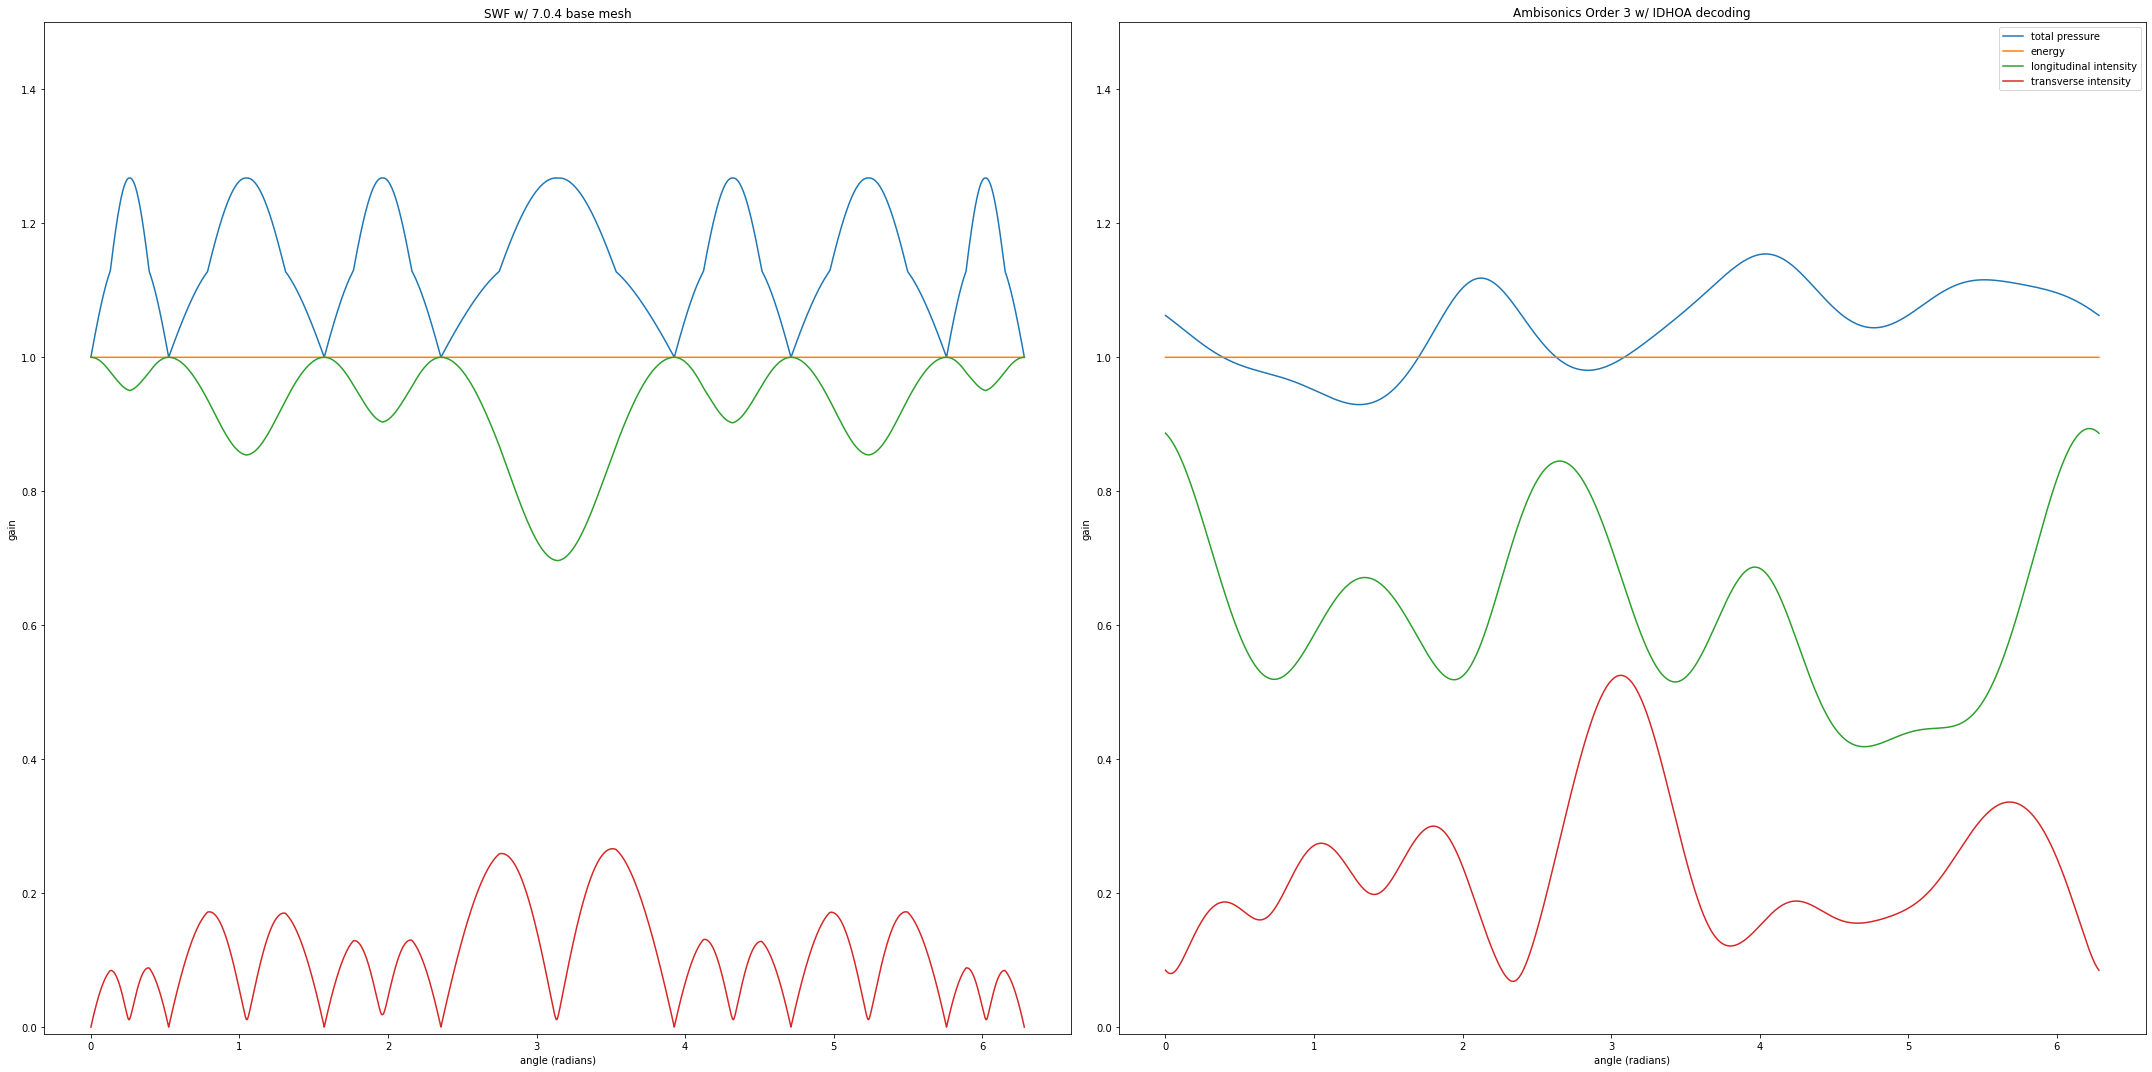

In [18]:
fig, subplots = plt.subplots(1,2,figsize=(30,15))

subplots[0].plot(theta,pressureSWF,label='total pressure')
subplots[0].plot(theta,energySWF,label='energy')
subplots[0].plot(theta,intensitySWF[:,0],label='longitudinal intensity')
subplots[0].plot(theta,intensitySWF[:,1],label='transverse intensity')

subplots[1].plot(theta,pressureAMB,label='total pressure')
subplots[1].plot(theta,energyAMB,label='energy')
subplots[1].plot(theta,intensityAMB[:,0],label='longitudinal intensity')
subplots[1].plot(theta,intensityAMB[:,1],label='transverse intensity')

subplots[0].set_title('SWF w/ 7.0.4 base mesh')
subplots[1].set_title('Ambisonics Order 3 w/ IDHOA decoding')

for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    splt.set_ylabel('gain')
    splt.set_ylim(-0.01,1.5)

subplots[1].legend(loc=1)
fig.tight_layout()

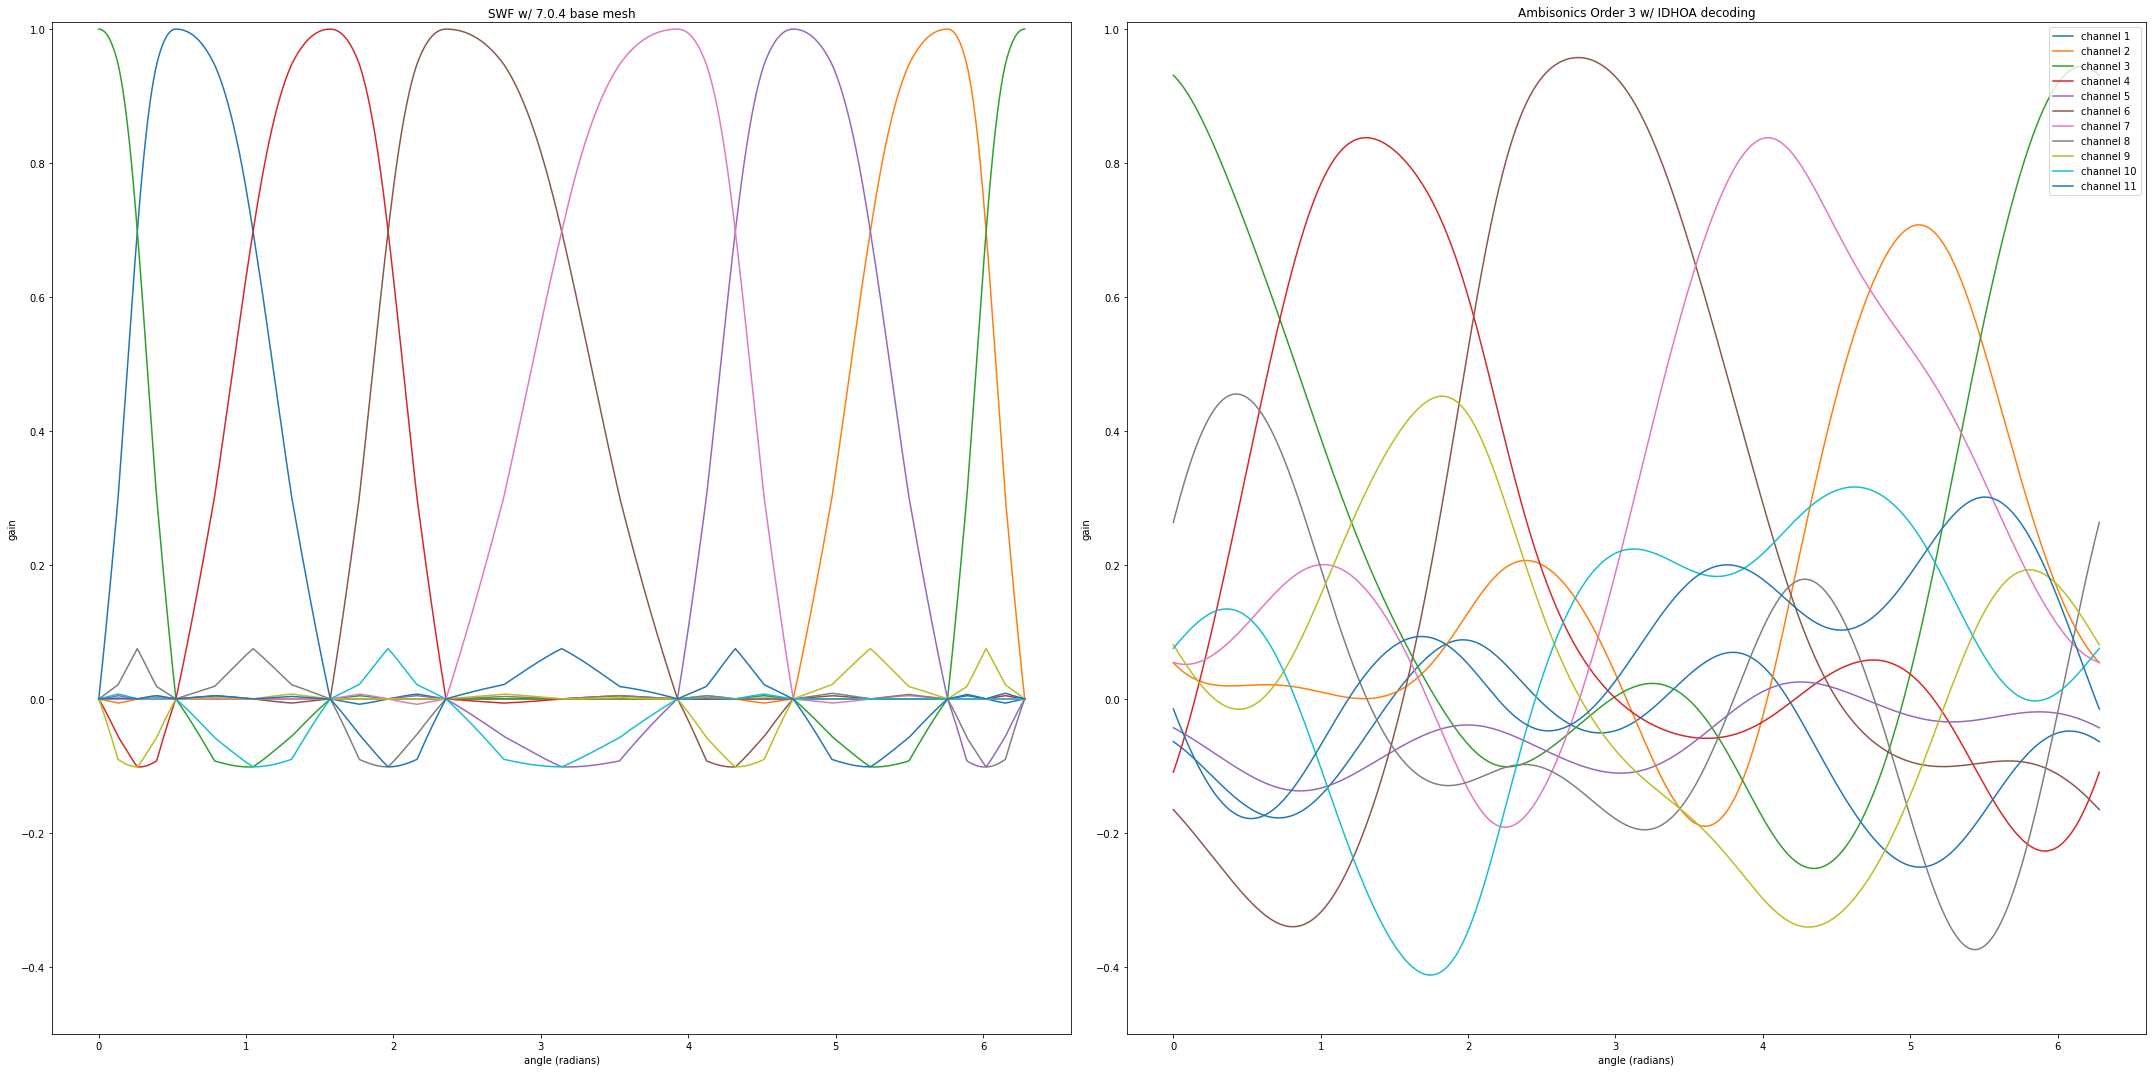

In [19]:
fig, subplots = plt.subplots(1,2,figsize=(30,15))

for i in range(11):
    subplots[0].plot(theta,swf_encoded[i],label=f'channel {i+1}')
    subplots[1].plot(theta,ambi_decoded[i],label=f'channel {i+1}')
    
subplots[0].set_title('SWF w/ 7.0.4 base mesh')
subplots[1].set_title('Ambisonics Order 3 w/ IDHOA decoding')

for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    splt.set_ylabel('gain')
    splt.set_ylim(-0.5,1.01)

subplots[1].legend(loc=1)
fig.tight_layout()

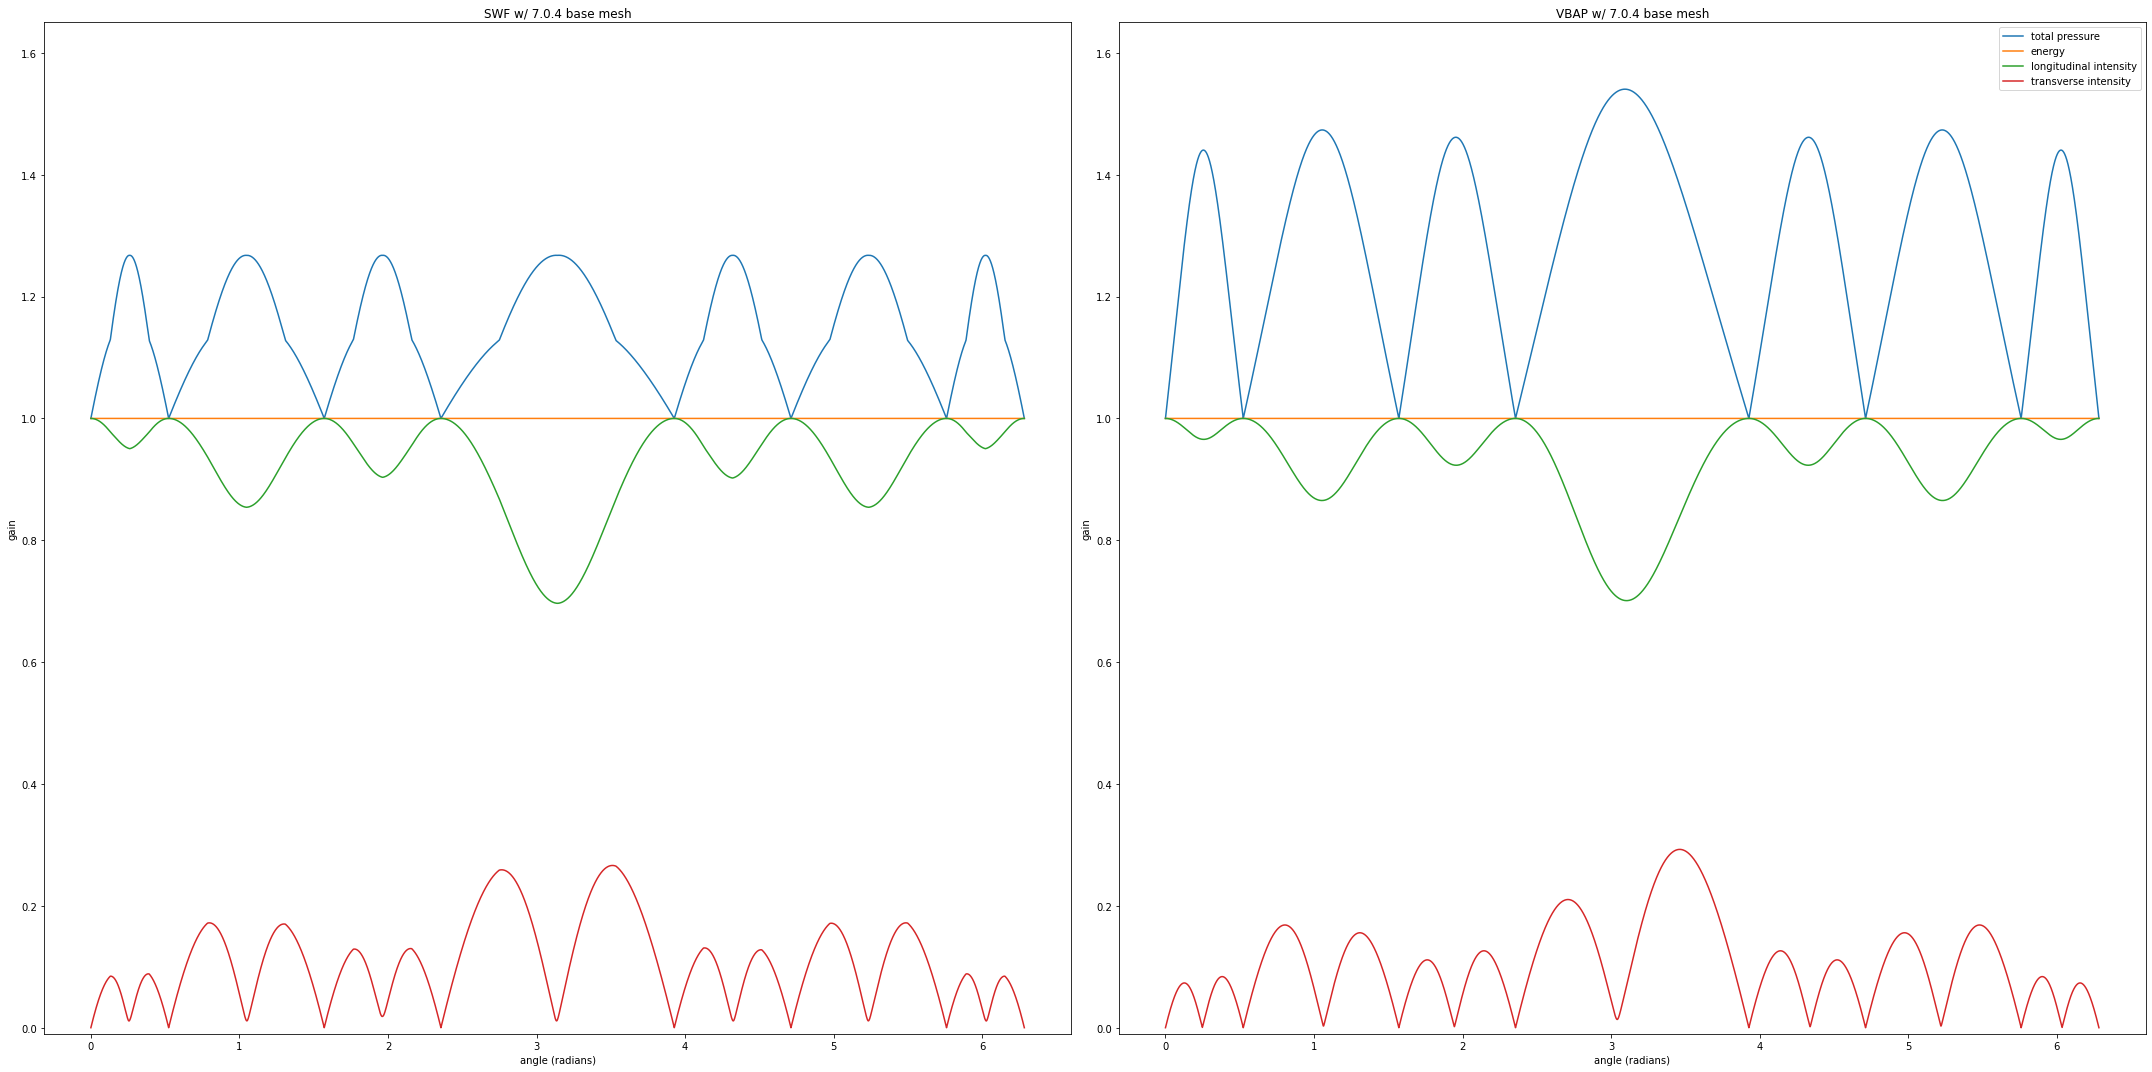

In [20]:
fig, subplots = plt.subplots(1,2,figsize=(30,15))

subplots[0].plot(theta,pressureSWF,label='total pressure')
subplots[0].plot(theta,energySWF,label='energy')
subplots[0].plot(theta,intensitySWF[:,0],label='longitudinal intensity')
subplots[0].plot(theta,intensitySWF[:,1],label='transverse intensity')

subplots[1].plot(theta,pressureVBAP,label='total pressure')
subplots[1].plot(theta,energyVBAP,label='energy')
subplots[1].plot(theta,intensityVBAP[:,0],label='longitudinal intensity')
subplots[1].plot(theta,intensityVBAP[:,1],label='transverse intensity')

subplots[0].set_title('SWF w/ 7.0.4 base mesh')
subplots[1].set_title('VBAP w/ 7.0.4 base mesh')

for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    splt.set_ylabel('gain')
    splt.set_ylim(-0.01,1.65)

subplots[1].legend(loc=1)
fig.tight_layout()

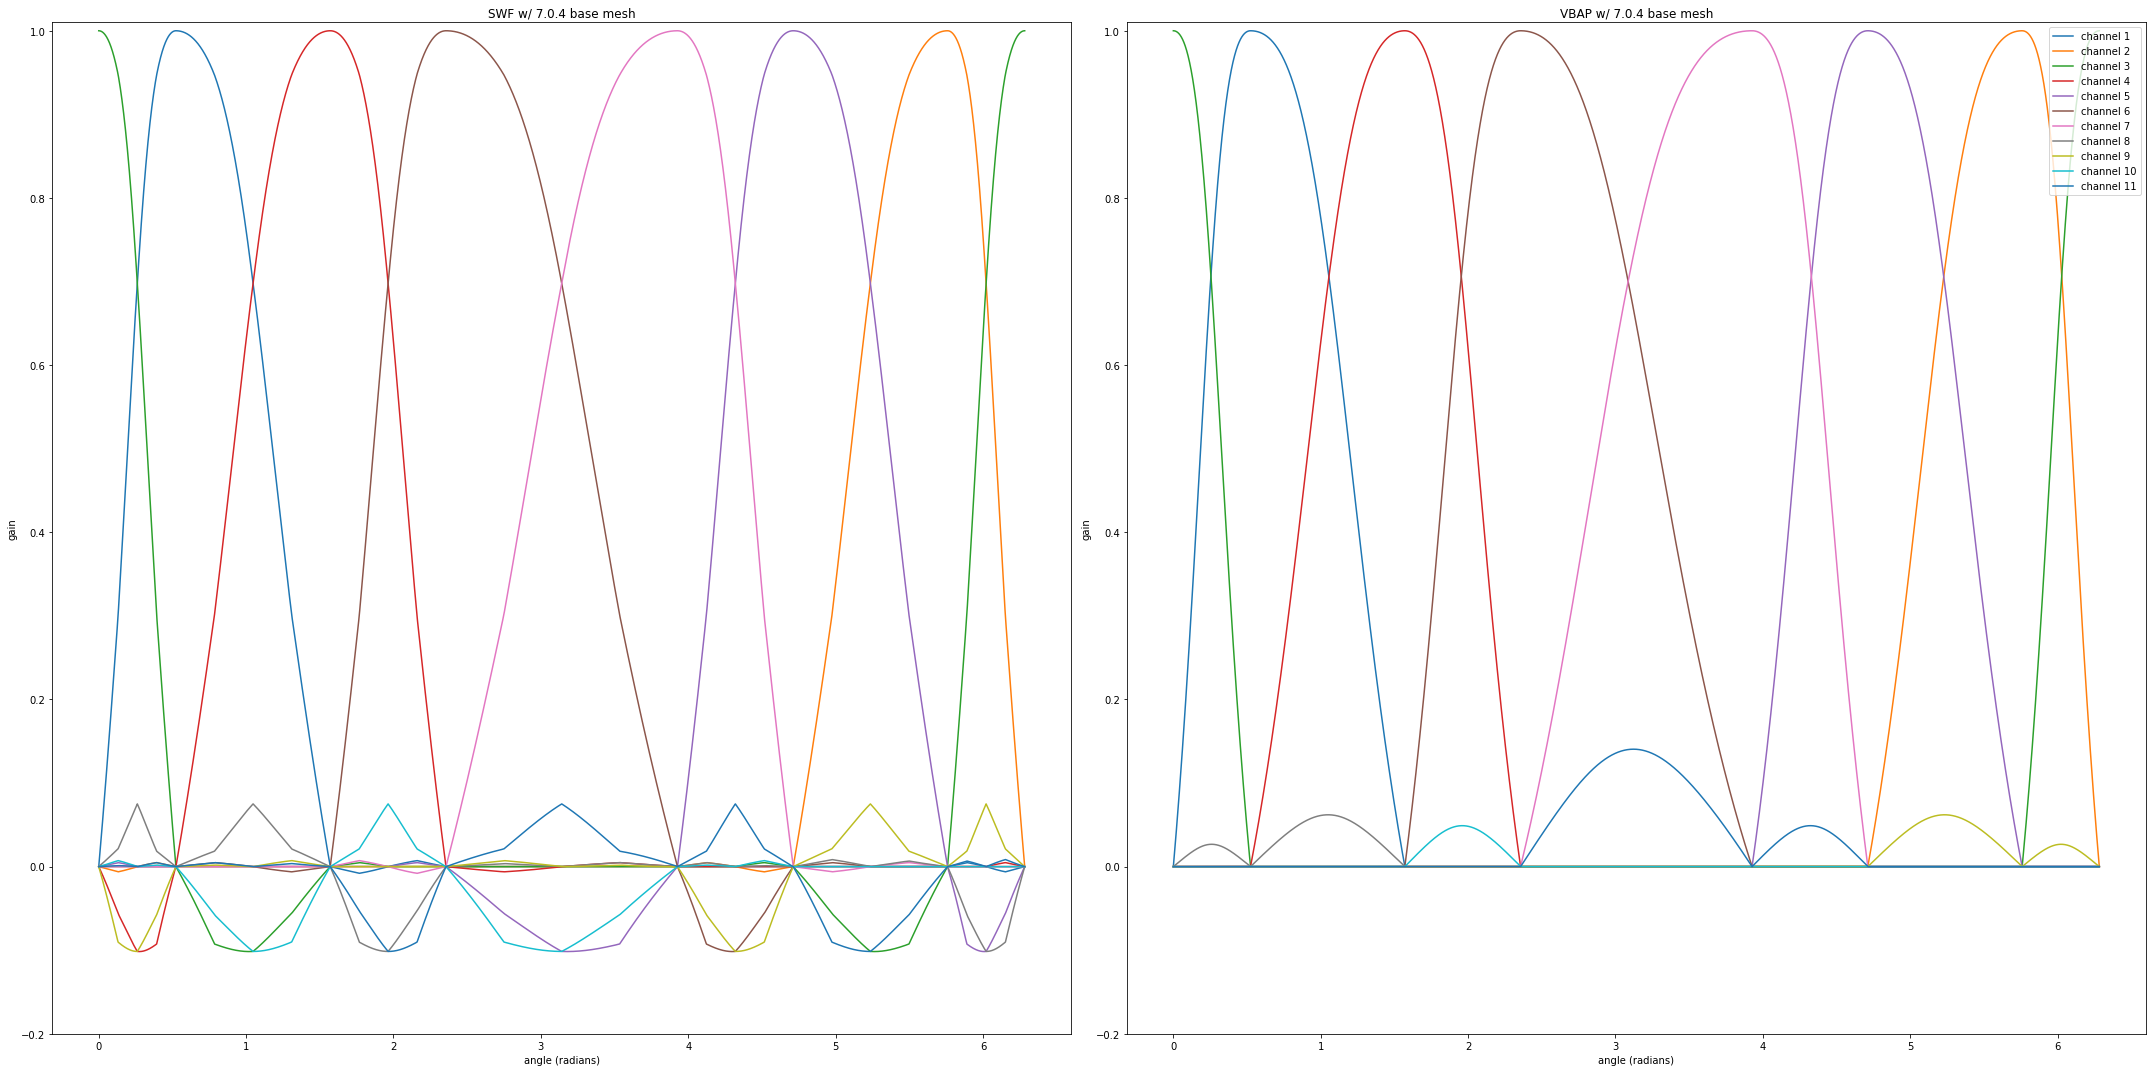

In [29]:
fig, subplots = plt.subplots(1,2,figsize=(30,15))

for i in range(11):
    subplots[0].plot(theta,swf_encoded[i],label=f'channel {i+1}')
    subplots[1].plot(theta,vbap[i],label=f'channel {i+1}')
    
subplots[0].set_title('SWF w/ 7.0.4 base mesh')
subplots[1].set_title('VBAP w/ 7.0.4 base mesh')

for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    splt.set_ylabel('gain')
    splt.set_ylim(-0.2,1.01)

subplots[1].legend(loc=1)
fig.tight_layout()